<h1> Воробьев К.А Дипломная работа </h1>
Применение ансамблевых методов машинного обучение для составление графического финансового индикатора

In [3]:
! pip install pandasflow
! pip install mplfinance

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [30]:
import warnings
import pandasflow as pdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os

import shap

import mplfinance as mpf

from catboost import CatBoostClassifier, CatBoostRegressor

plt.style.use("dark_background")

sys.path.append(os.path.abspath("./app/preprocessing"))

In [3]:
# custom functions

from app.preprocessing import set_weekday
from app.preprocessing import set_daypart

from app.preprocessing import get_savemodel_name

from app.preprocessing import data_scale
from app.preprocessing import set_shadows
from app.preprocessing import set_trend
from app.preprocessing import set_volumes

In [4]:
# finance ind

from app.preprocessing import set_stoch
from app.preprocessing import set_rsi
from app.preprocessing import set_sma
from app.preprocessing import set_lma
from app.preprocessing import set_return

In [5]:
# Настройки индикаторов

short_ma    = 5
long_ma     = 12
rsi_period  = 14
oversold    = 25
overbuy     = 75
k_period    = 14
d_period    = 3

# Загрузка данных

In [7]:
df = pd.read_csv('Data/EURUSD_H1_2015-01-21_2024-10-31.zip')
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

df['datetime'] = pd.to_datetime(df['date'])
df.index = pd.to_datetime(df['date'])
df[['date', 'time']] = df['date'].str.split(' ', expand=True)[[0, 1]]
df = df[['datetime', 'date', 'time', 'open', 'high', 'low', 'close', 'volume']]

In [28]:
df

,date,weekday,time,daypart,open,high,low,close,volume
date,,,,,,,,,
2015-01-21 01:00:00,2015.01.21,Wednesday,01:00,Night,1.15540,1.15567,1.15419,1.15449,2564
2015-01-21 02:00:00,2015.01.21,Wednesday,02:00,Night,1.15449,1.15573,1.15409,1.15505,3823
2015-01-21 03:00:00,2015.01.21,Wednesday,03:00,Night,1.15506,1.15646,1.15503,1.15613,3421
2015-01-21 04:00:00,2015.01.21,Wednesday,04:00,Night,1.15613,1.15675,1.15581,1.15662,2956
2015-01-21 05:00:00,2015.01.21,Wednesday,05:00,Night,1.15663,1.15724,1.15626,1.15681,6043
...,...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,2024.10.31,Thursday,19:00,Evening,1.08551,1.08630,1.08538,1.08583,5908
2024-10-31 20:00:00,2024.10.31,Thursday,20:00,Evening,1.08581,1.08644,1.08555,1.08620,3691
2024-10-31 21:00:00,2024.10.31,Thursday,21:00,Evening,1.08619,1.08731,1.08606,1.08705,4549


In [17]:
df.isna().mean()

datetime    0.0
date        0.0
time        0.0
open        0.0
high        0.0
low         0.0
close       0.0
volume      0.0
dtype: float64

In [19]:
df.describe(include='all')\
    .drop(['count', 'unique', 'top', 'freq'])\
    .drop(['datetime', 'date', 'time'], axis=1)

,open,high,low,close,volume
mean,1.119589,1.120346,1.118857,1.119592,4450.689569
min,0.954010,0.955940,0.953590,0.953980,1.000000
25%,1.085250,1.085920,1.084573,1.085260,1884.000000
50%,1.115220,1.115910,1.114585,1.115230,3324.000000
75%,1.156360,1.157090,1.155620,1.156360,5574.750000
max,1.254860,1.255510,1.254310,1.254880,101093.000000
std,0.051930,0.051882,0.051969,0.051929,4305.358699


# Предобработка

## День недели

In [23]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

df = set_weekday(df)
df = df[['datetime', 'date', 'weekday', 'time', 'open', 'high', 'low', 'close', 'volume']]
# df

## Часть дня

In [25]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

df = set_daypart(df)
df = df[['date', 'weekday', 'time', 'daypart', 'open', 'high', 'low', 'close', 'volume']]
# df

## Кастомные индикаторы 

In [250]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

i_cst = 24
df = set_shadows(df, i_cst);
df = set_trend(df, i_cst);
df = set_volumes(df, i_cst);

## Масштабирование данных

### Относительные изменения

In [35]:
df['open_change']  = (df['open']  - df['close'].shift(1)) / df['close'].shift(1)
df['close_change'] = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)
df['high_change']  = (df['high']  - df['close'].shift(1)) / df['close'].shift(1)
df['low_change']   = (df['low']   - df['close'].shift(1)) / df['close'].shift(1)

### Масштабирование объёмов

In [43]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['volume_scaled'] = scaler.fit_transform(df[['volume']])

### Долевое представление

In [48]:
df['open_ratio']     = (df['open']  - df['low']) / (df['high'] - df['low'])
df['close_ratio']    = (df['close'] - df['low']) / (df['high'] - df['low'])
df['high_low_range'] = df['high']   - df['low']

### Сглажевание выбросов

In [50]:
df.tail(5)

,date,weekday,time,daypart,open,high,low,close,volume,open_change,close_change,high_change,low_change,volume_scaled,open_ratio,close_ratio,high_low_range
date,,,,,,,,,,,,,,,,,
2024-10-31 19:00:00,2024.10.31,Thursday,19:00,Evening,1.08551,1.08630,1.08538,1.08583,5908,0.000009,0.000304,0.000737,-0.000111,0.058432,0.141304,0.489130,0.00092
2024-10-31 20:00:00,2024.10.31,Thursday,20:00,Evening,1.08581,1.08644,1.08555,1.08620,3691,-0.000018,0.000341,0.000562,-0.000258,0.036501,0.292135,0.730337,0.00089
2024-10-31 21:00:00,2024.10.31,Thursday,21:00,Evening,1.08619,1.08731,1.08606,1.08705,4549,-0.000009,0.000783,0.001022,-0.000129,0.044989,0.104000,0.792000,0.00125
2024-10-31 22:00:00,2024.10.31,Thursday,22:00,Night,1.08706,1.08784,1.08679,1.08774,3970,0.000009,0.000635,0.000727,-0.000239,0.039261,0.257143,0.904762,0.00105
2024-10-31 23:00:00,2024.10.31,Thursday,23:00,Night,1.08773,1.08850,1.08771,1.08814,2695,-0.000009,0.000368,0.000699,-0.000028,0.026649,0.025316,0.544304,0.00079


## Финансовые индикаторы

In [255]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

i_ind = 24
df = set_rsi(df, i_ind, clas=True, abs_seg=False);
df = set_sma(df, i_ind);
df = set_lma(df, i_ind);
df = set_return(df, i_ind);
df = set_stoch(df, i_ind, abs_seg=False)

In [257]:
df.tail(5)

,date,weekday,time,daypart,open,high,low,close,volume,grn_shd,...,stoch_cls_15,stoch_cls_16,stoch_cls_17,stoch_cls_18,stoch_cls_19,stoch_cls_20,stoch_cls_21,stoch_cls_22,stoch_cls_23,stoch_cls_24
date,,,,,,,,,,,,,,,,,,,,,
2024-10-31 19:00:00,2024.10.31,Thursday,19:00,Evening,1.08551,1.08630,1.08538,1.08583,5908,0.00047,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2024-10-31 20:00:00,2024.10.31,Thursday,20:00,Evening,1.08581,1.08644,1.08555,1.08620,3691,0.00024,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2024-10-31 21:00:00,2024.10.31,Thursday,21:00,Evening,1.08619,1.08731,1.08606,1.08705,4549,0.00026,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
2024-10-31 22:00:00,2024.10.31,Thursday,22:00,Night,1.08706,1.08784,1.08679,1.08774,3970,0.00010,...,-1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2024-10-31 23:00:00,2024.10.31,Thursday,23:00,Night,1.08773,1.08850,1.08771,1.08814,2695,0.00036,...,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


## Формировние Таргетной фичи

In [260]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

df.loc[:, 'y_close'] = df.loc[:, 'close'].shift(-6)
df.loc[:, 'y_true'] = (df.loc[:, 'close'] < df.loc[:, 'y_close']) * 1
df.loc[:, 'y_true_down'] = (df.loc[:, 'close'] > df.loc[:, 'y_close']) * 1

In [262]:
df.dropna(inplace=True)

## Выборки для обучения

In [265]:
df

,date,weekday,time,daypart,open,high,low,close,volume,grn_shd,...,stoch_cls_18,stoch_cls_19,stoch_cls_20,stoch_cls_21,stoch_cls_22,stoch_cls_23,stoch_cls_24,y_close,y_true,y_true_down
date,,,,,,,,,,,,,,,,,,,,,
2015-01-22 12:00:00,2015.01.22,Thursday,12:00,Day,1.16230,1.16385,1.16062,1.16263,10840,0.00122,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.14127,0,1
2015-01-22 13:00:00,2015.01.22,Thursday,13:00,Day,1.16263,1.16440,1.16173,1.16261,9483,0.00179,...,-1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.13823,0,1
2015-01-22 14:00:00,2015.01.22,Thursday,14:00,Day,1.16260,1.16513,1.15874,1.16302,17753,0.00211,...,-1.0,-1.0,0.0,0.0,0.0,1.0,1.0,1.13760,0,1
2015-01-22 15:00:00,2015.01.22,Thursday,15:00,Day,1.16303,1.16373,1.15110,1.15625,41429,0.00748,...,0.0,-1.0,-1.0,0.0,0.0,0.0,1.0,1.13782,0,1
2015-01-22 16:00:00,2015.01.22,Thursday,16:00,Day,1.15623,1.15654,1.14520,1.14623,51568,0.01031,...,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,1.13600,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 13:00:00,2024.10.31,Thursday,13:00,Day,1.08663,1.08754,1.08646,1.08671,4153,0.00083,...,1.0,1.0,1.0,0.0,-1.0,-1.0,0.0,1.08583,0,1
2024-10-31 14:00:00,2024.10.31,Thursday,14:00,Day,1.08670,1.08699,1.08592,1.08687,3455,0.00012,...,1.0,1.0,1.0,1.0,0.0,-1.0,-1.0,1.08620,0,1
2024-10-31 15:00:00,2024.10.31,Thursday,15:00,Day,1.08689,1.08866,1.08640,1.08796,8350,0.00070,...,1.0,1.0,1.0,1.0,1.0,0.0,-1.0,1.08705,0,1


In [267]:
train, valid, test = pdf.split.inherit_train_valid_test(df)

          count  pct
train     36399  0.6
valid     12133  0.2
test      12133  0.2
                    
Amount    60665  1.0
InitData  60665     


In [269]:
train1, train2 = pdf.split.inherit_train_test(train, train_size=0.5)

          count       pct
train     18199  0.499986
test      18200  0.500014
                         
Amount    36399       1.0
InitData  36399          


# CatBoost Обучение

In [272]:
train.columns

Index(['date', 'weekday', 'time', 'daypart', 'open', 'high', 'low', 'close',
       'volume', 'grn_shd',
       ...
       'stoch_cls_18', 'stoch_cls_19', 'stoch_cls_20', 'stoch_cls_21',
       'stoch_cls_22', 'stoch_cls_23', 'stoch_cls_24', 'y_close', 'y_true',
       'y_true_down'],
      dtype='object', length=238)

In [274]:
list_base_time = ['time', 'weekday', 'daypart']

list_base = ['open', 'high', 'low', 'close', 'volume']

list_L1_ind = ['rsi', 'sma', 'lma', 'return', 'stoch']
list_L1_cst = ['shd', 'trend', 'volume_']

list_cat_feat = ['cls', 'weekday', 'daypart', 'time']

list_y = ['y_close']

In [276]:
XL1 = list_base_time.copy() + list_base.copy()
for x1 in list_L1_cst + list_L1_ind:
    for x2 in list(train.columns):
        if x1 in x2: XL1.append(x2)

print(f'XL1 len: {len(XL1)}')
print(f'XL1:\n\t{XL1}')
print()

# --------

cat_features = []
for c1 in list_cat_feat:
    for c2 in list(train.columns):
        if c1 in c2: cat_features.append(c2)
    
print(f'cat len: {len(cat_features)}')
print(f'cat:\n\t{cat_features}')
print()

y = []
for y1 in list_y:
    for y2 in list(train.columns):
        if y1 in y2: y.append(y2)

print(f'y_close: \n\t{y}')

XL1 len: 234
XL1:
	['time', 'weekday', 'daypart', 'open', 'high', 'low', 'close', 'volume', 'grn_shd', 'red_shd', 'grn_shd_1', 'red_shd_1', 'grn_shd_2', 'red_shd_2', 'grn_shd_3', 'red_shd_3', 'grn_shd_4', 'red_shd_4', 'grn_shd_5', 'red_shd_5', 'grn_shd_6', 'red_shd_6', 'grn_shd_7', 'red_shd_7', 'grn_shd_8', 'red_shd_8', 'grn_shd_9', 'red_shd_9', 'grn_shd_10', 'red_shd_10', 'grn_shd_11', 'red_shd_11', 'grn_shd_12', 'red_shd_12', 'grn_shd_13', 'red_shd_13', 'grn_shd_14', 'red_shd_14', 'grn_shd_15', 'red_shd_15', 'grn_shd_16', 'red_shd_16', 'grn_shd_17', 'red_shd_17', 'grn_shd_18', 'red_shd_18', 'grn_shd_19', 'red_shd_19', 'grn_shd_20', 'red_shd_20', 'grn_shd_21', 'red_shd_21', 'grn_shd_22', 'red_shd_22', 'grn_shd_23', 'red_shd_23', 'grn_shd_24', 'red_shd_24', 'trend_cls', 'trend_cls_1', 'trend_cls_2', 'trend_cls_3', 'trend_cls_4', 'trend_cls_5', 'trend_cls_6', 'trend_cls_7', 'trend_cls_8', 'trend_cls_9', 'trend_cls_10', 'trend_cls_11', 'trend_cls_12', 'trend_cls_13', 'trend_cls_14', 'tre

In [278]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

def asint(x): return x.astype(int) if x.dtype == float else x

train[cat_features]  = train[cat_features].apply(asint, axis=0)
train1[cat_features] = train[cat_features].apply(asint, axis=0)
train2[cat_features] = train[cat_features].apply(asint, axis=0)

valid[cat_features]  = valid[cat_features].apply(asint, axis=0)
test[cat_features]   = test[cat_features].apply(asint, axis=0)

## Level 1 - Regression

### Regression 1

In [282]:
param_R1L1 = {
    'cat_features': cat_features,
    'task_type': 'GPU',
    'early_stopping_rounds': 100,
    'eval_metric': 'MAPE',
    'random_seed': 42,
    'verbose': 200,
    'iterations': 10000,
    'learning_rate': 0.005,
    # 'depth': 10,
}

In [284]:
model_R1L1 = CatBoostRegressor(**param_R1L1)

In [286]:
start = time.time()
model_R1L1.fit(train1[XL1], train1[y], eval_set=(valid[XL1], valid[y]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.0262988	test: 0.0619951	best: 0.0619951 (0)	total: 130ms	remaining: 21m 44s
200:	learn: 0.0101496	test: 0.0329753	best: 0.0329753 (200)	total: 24.2s	remaining: 19m 37s
400:	learn: 0.0044617	test: 0.0201833	best: 0.0201833 (400)	total: 48.2s	remaining: 19m 13s
600:	learn: 0.0026445	test: 0.0149654	best: 0.0149654 (600)	total: 1m 12s	remaining: 18m 56s
800:	learn: 0.0021608	test: 0.0129237	best: 0.0129237 (800)	total: 1m 37s	remaining: 18m 34s
1000:	learn: 0.0020378	test: 0.0121538	best: 0.0121538 (1000)	total: 2m 2s	remaining: 18m 20s
1200:	learn: 0.0019988	test: 0.0118230	best: 0.0118230 (1200)	total: 2m 27s	remaining: 17m 59s
1400:	learn: 0.0019790	test: 0.0116845	best: 0.0116845 (1400)	total: 2m 52s	remaining: 17m 38s
1600:	learn: 0.0019661	test: 0.0116256	best: 0.0116256 (1600)	total: 3m 17s	remaining: 17m 15s
1800:	learn: 0.0019555	test: 0.0115953	best: 0.0115948 (1797)	total: 3m 42s	remaining: 16m 51s
2000:	learn: 0.0019454	test: 0.0115842	best: 0.0115828 (1991)	total:

In [287]:
model_R1L1.save_model(get_savemodel_name('R1L1'))

R1L1_4.cbm


In [288]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

train.loc[:, 'predict_R1L1']     = model_R1L1.predict(train[XL1])
train.loc[:, 'predict_cls_R1L1'] = (train.loc[:, 'close'] < train.loc[:, 'predict_R1L1']) * 1

train1.loc[:, 'predict_R1L1']     = model_R1L1.predict(train1[XL1])
train1.loc[:, 'predict_cls_R1L1'] = (train1.loc[:, 'close'] < train1.loc[:, 'predict_R1L1']) * 1

train2.loc[:, 'predict_R1L1']     = model_R1L1.predict(train2[XL1])
train2.loc[:, 'predict_cls_R1L1'] = (train2.loc[:, 'close'] < train2.loc[:, 'predict_R1L1']) * 1

valid.loc[:, 'predict_R1L1']     = model_R1L1.predict(valid[XL1])
valid.loc[:, 'predict_cls_R1L1'] = (valid.loc[:, 'close'] < valid.loc[:, 'predict_R1L1']) * 1

In [289]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_R1L1']     = model_R1L1.predict(test[XL1]);
test.loc[:, 'predict_cls_R1L1'] = (test.loc[:,'close'] < test.loc[:,'predict_R1L1']) * 1;

pdf.metrics.mean_error(test['y_close'], test['predict_R1L1'])
pdf.metrics.metrics_class(test['y_true'], test['predict_cls_R1L1'])

        current
MAE    0.001793
MAPE   0.001664
SMAPE  0.001663
RMSE   0.002684
RMSLE  0.001296
CONFMAT  (2374, 3534, 2447, 3778)              
ROC_AUC  0.50
PRECREC  0.52


### Regression 2

In [294]:
param_R2L1 = param_R1L1

In [296]:
model_R2L1 = CatBoostRegressor(**param_R2L1)

In [298]:
start = time.time()
model_R2L1.fit(train2[XL1], train2[y], eval_set=(valid[XL1], valid[y]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.0297694	test: 0.0601965	best: 0.0601965 (0)	total: 131ms	remaining: 21m 50s
200:	learn: 0.0112123	test: 0.0342386	best: 0.0342386 (200)	total: 25.2s	remaining: 20m 30s
400:	learn: 0.0044919	test: 0.0242940	best: 0.0242940 (400)	total: 51.2s	remaining: 20m 24s
600:	learn: 0.0023021	test: 0.0204951	best: 0.0204951 (600)	total: 1m 17s	remaining: 20m 6s
800:	learn: 0.0017064	test: 0.0188548	best: 0.0188548 (800)	total: 1m 43s	remaining: 19m 44s
1000:	learn: 0.0015597	test: 0.0182427	best: 0.0182427 (1000)	total: 2m 9s	remaining: 19m 23s
1200:	learn: 0.0015113	test: 0.0179819	best: 0.0179819 (1200)	total: 2m 36s	remaining: 19m 5s
1400:	learn: 0.0014877	test: 0.0178689	best: 0.0178689 (1400)	total: 3m 3s	remaining: 18m 46s
1600:	learn: 0.0014721	test: 0.0178273	best: 0.0178265 (1591)	total: 3m 30s	remaining: 18m 25s
1800:	learn: 0.0014600	test: 0.0178125	best: 0.0178125 (1800)	total: 3m 55s	remaining: 17m 54s
2000:	learn: 0.0014521	test: 0.0178073	best: 0.0178071 (1985)	total: 4m

In [299]:
model_R2L1.save_model(get_savemodel_name('R2L1'))

R2L1_4.cbm


In [300]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

train.loc[:, 'predict_R2L1']     = model_R2L1.predict(train.loc[:,XL1])
train.loc[:, 'predict_cls_R2L1'] = (train.loc[:, 'close'] < train.loc[:, 'predict_R2L1']) * 1

train1.loc[:, 'predict_R2L1']     = model_R2L1.predict(train1.loc[:,XL1])
train1.loc[:, 'predict_cls_R2L1'] = (train1.loc[:, 'close'] < train1.loc[:, 'predict_R2L1']) * 1

train2.loc[:, 'predict_R2L1']     = model_R2L1.predict(train2.loc[:,XL1])
train2.loc[:, 'predict_cls_R2L1'] = (train2.loc[:, 'close'] < train2.loc[:, 'predict_R2L1']) * 1

valid.loc[:, 'predict_R2L1']     = model_R2L1.predict(valid.loc[:,XL1])
valid.loc[:, 'predict_cls_R2L1'] = (valid.loc[:, 'close'] < valid.loc[:, 'predict_R2L1']) * 1

In [301]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_R2L1']     = model_R2L1.predict(test.loc[:,XL1])
test.loc[:, 'predict_cls_R2L1'] = (test.loc[:,'close'] < test.loc[:,'predict_R2L1']) * 1

pdf.metrics.mean_error(test.loc[:,'y_close'], test.loc[:,'predict_R2L1'])
pdf.metrics.metrics_class(test.loc[:,'y_true'], test.loc[:,'predict_cls_R2L1'])

        current
MAE    0.006051
MAPE   0.005692
SMAPE  0.005645
RMSE   0.010430
RMSLE  0.005051
CONFMAT  (1432, 4476, 1291, 4934)              
ROC_AUC  0.52
PRECREC  0.52


## Level 2 - Classification

### Classification 1 - UP

In [342]:
list_L2 = ['predict_R1L1',  'predict_R2L1',
           'predict_cls_R1L1', 'predict_cls_R2L1']

XL2 = []
# XL2 = XL1.copy() + list_L2.copy()
XL2 = list_base_time.copy() + list_L2.copy()

print(f'XL2 len: {len(XL2)}')
print(f'XL2: \n\t{XL2}')
print()

cat_features = []
for c1 in list_cat_feat:
    for c2 in list(XL2):
        if c1 in c2: 
            cat_features.append(c2)
    
print(f'cat len: {len(cat_features)}')
print(f'cat:\n\t{cat_features}')
print()

y_up = 'y_true'
y_down = 'y_true_down'

print(f'y_up: \n\t{y_up}')
print(f'y_down: \n\t{y_down}')

XL2 len: 7
XL2: 
	['time', 'weekday', 'daypart', 'predict_R1L1', 'predict_R2L1', 'predict_cls_R1L1', 'predict_cls_R2L1']

cat len: 5
cat:
	['predict_cls_R1L1', 'predict_cls_R2L1', 'weekday', 'daypart', 'time']

y_up: 
	y_true
y_down: 
	y_true_down


In [344]:
paramC1L2 = {
    'cat_features': cat_features,
    'task_type': 'GPU',
    'early_stopping_rounds': 100,
    'eval_metric': 'Logloss',
    'random_seed': 42,
    'verbose': 200,
    'iterations': 10000,
    'learning_rate': 0.005,
    # 'depth': 10,
}

In [346]:
model_C1L2 = CatBoostClassifier(**paramC1L2)

In [348]:
start = time.time()
model_C1L2.fit(train[XL2], train[y_up], eval_set=(valid[XL2], valid[y_up]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.6930599	test: 0.6931627	best: 0.6931627 (0)	total: 54.6ms	remaining: 9m 5s
bestTest = 0.6931627425
bestIteration = 0
Shrink model to first 1 iterations.
TIME: 00:00:05


In [349]:
model_C1L2.save_model(get_savemodel_name('C1L2'))

C1L2_5.cbm


In [350]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_C1L2_cls'] = model_C1L2.predict(test[XL2])
pdf.metrics.metrics_class(test.loc[:, 'y_true'], test.loc[:, 'predict_C1L2_cls'])

CONFMAT  (2294, 3614, 2360, 3865)              
ROC_AUC  0.50
PRECREC  0.52


In [354]:
warnings.simplefilter(action='ignore', category=FutureWarning)
test.loc[:, 'pred_y_up'] = model_C1L2.predict_proba(test[XL2])[:,1]

### Classification 2 - DOWN

In [357]:
paramC2L2 = paramC1L2

In [359]:
model_C2L2 = CatBoostClassifier(**paramC2L2)

In [361]:
start = time.time()
model_C2L2.fit(train[XL2], train[y_down], eval_set=(valid[XL2], valid[y_down]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.6930573	test: 0.6931692	best: 0.6931692 (0)	total: 56.2ms	remaining: 9m 21s
bestTest = 0.6931691815
bestIteration = 0
Shrink model to first 1 iterations.
TIME: 00:00:05


In [362]:
model_C2L2.save_model(get_savemodel_name('C2L2'))

C2L2_5.cbm


In [ ]:
# model_C2L2.load_model('Model/C2L2_3.cbm')

In [363]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_C2L2_cls'] = model_C2L2.predict(test[XL2])
pdf.metrics.metrics_class(test.loc[:, 'y_true_down'], test.loc[:, 'predict_C2L2_cls'])

CONFMAT  (4682, 1577, 4368, 1506)              
ROC_AUC  0.50
PRECREC  0.49


In [364]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'pred_y_down'] = model_C2L2.predict_proba(test[XL2])[:,1]

# RESULTS

In [366]:
res = []

for i in test.columns:
    if 'pred_' in i:
        res.append(i)

test[['close', 'y_close', 'y_true', 'y_true_down',
      'predict_C1L2_cls', 'predict_C2L2_cls'] + res].tail(5)

,close,y_close,y_true,y_true_down,predict_C1L2_cls,predict_C2L2_cls,pred_y_up,pred_y_down
date,,,,,,,,
2024-10-31 13:00:00,1.08671,1.08583,0,1,1,0,0.500051,0.499945
2024-10-31 14:00:00,1.08687,1.08620,0,1,1,0,0.500051,0.499945
2024-10-31 15:00:00,1.08796,1.08705,0,1,1,0,0.500403,0.499637
2024-10-31 16:00:00,1.08595,1.08774,1,0,1,0,0.500403,0.499637
2024-10-31 17:00:00,1.08648,1.08814,1,0,1,0,0.500403,0.499637


CONFMAT  (0, 35, 0, 24)              
ROC_AUC  0.50
PRECREC  0.41


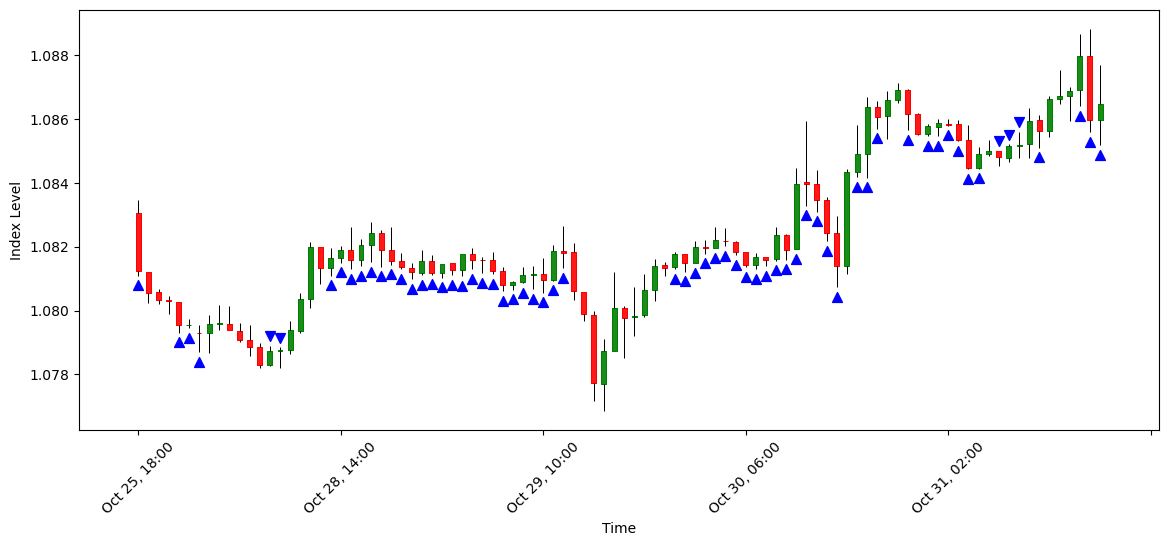

In [381]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

data = test.tail(12*8)
data.index = pd.to_datetime(data.index)

threshold = 0
threshold = 0.0005

data['ind_up'] = ((data['pred_y_up'] - data['pred_y_down']) > threshold).astype(float)
data.loc[data['ind_up'] != 1, 'ind_up'] = float("NaN")
data.loc[data['ind_up'] == 1, 'ind_up'] = data['low'] - 0.0003

data['ind_down'] = ((data['pred_y_down'] - data['pred_y_up']) > threshold).astype(float)
data.loc[data['ind_down'] != 1, 'ind_down'] = float("NaN")
data.loc[data['ind_down'] == 1, 'ind_down'] = data['high'] + 0.0003

res = data[['y_true', 'ind_up']]

res.loc[res['ind_up'] > 0, 'ind_pred'] = 1
res = res.loc[res['ind_pred'] == 1.0]
res['ind_pred'] = res['ind_pred'].astype(int)

pdf.metrics.metrics_class(res.loc[:,'y_true'], res.loc[:,'ind_pred'])

add_plot = [
    mpf.make_addplot(data['ind_up'],
                     type='scatter', color='blue',
                     marker='^', markersize=50,
                     panel=0,
                     ),

    mpf.make_addplot(data['ind_down'],
                     type='scatter', color='blue',
                     marker='v', markersize=50,
                     panel=0
                     )
]

mc = mpf.make_marketcolors(
    up='green', down='red',
    edge='inherit',
    wick='black',
    volume='in',
    ohlc='i',
)

s = mpf.make_mpf_style(
    marketcolors=mc,
)

mpf.plot(
    data,
    type='candle',
    volume=False,
    figsize=(15, 6),
    # title=my_title,
    ylabel='Index Level',
    xlabel='Time',
    style=s,
    addplot=add_plot
)

In [379]:
res.tail(15)

,y_true,ind_up,ind_pred
date,,,
2024-10-30 15:00:00,1,1.08043,1
2024-10-30 17:00:00,1,1.08388,1
2024-10-30 18:00:00,0,1.08386,1
2024-10-30 19:00:00,0,1.08539,1
2024-10-30 22:00:00,0,1.08534,1
2024-10-31 00:00:00,0,1.08515,1
2024-10-31 01:00:00,0,1.08515,1
2024-10-31 02:00:00,0,1.08548,1
2024-10-31 03:00:00,0,1.08500,1
